In [41]:
import rasterio
import geopandas as gpd
import pandas as pd
from rasterio import mask
from shapely.geometry import shape
import json
import numpy as np
from tqdm import tqdm
from random import randint
import random
import nso_ds_classes.nso_tif_kernel as nso_tif_kernel
import nso_ds_classes.nso_ds_models as nso_ds_models
import glob
import geopandas as gpd
import os
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras import layers
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import load_model
import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
def __make_the_crop(load_shape, raster_path, raster_path_cropped):
    """
        This crops the sattelite image with a chosen shape.

        TODO: Make this accept a object of geopandas or shapely and crs independant.
        @param load_schape: path to a geojson shape file.
        @param raster_path_wgs: path to the raster .tiff file.
        @param raster_path_cropped: path were the cropped raster will be stored.
    """
    geo_file = gpd.read_file(load_shape)
    src = rasterio.open(raster_path)

    # Change the crs to rijks driehoek, because all the satelliet images are in rijks driehoek
    if geo_file.crs != 'epsg:28992':
        geo_file = geo_file.to_crs(epsg=28992)

    out_image, out_transform = rasterio.mask.mask(src,geo_file['geometry'], crop=True, filled=True)
    out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rasterio.open(raster_path_cropped, "w", **out_meta) as dest:
            dest.write(out_image)
            dest.close()
            
def retrieve_kernel(cor_x, cor_y):
    try:
        return tif_kernel_generator.get_kernel_for_x_y(cor_x, cor_y)
    except Exception as e:
        print(e)
        return None

def euclidean_distance_kernels(kernel_x, kernel_y):
    return np.sum(np.abs(kernel_x - kernel_y))

def predict(kernel,annotations, fade = True):
    
    if fade == True:
        return annotations[np.argmin([euclidean_distance_kernels(tif_kernel_generator.fadify_kernel(label[1]),\
                                                                 tif_kernel_generator.fadify_kernel(kernel))\
               for label in annotations])][0]
    elif fade == False:
        return annotations[np.argmin([euclidean_distance_kernels(label[1],\
                                                                 kernel)\
                   for label in annotations])][0]


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    figure(figsize=(10, 6), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(annotations['label'].unique()))
    plt.xticks(tick_marks, annotations['label'].unique(), rotation=45)
    plt.yticks(tick_marks, annotations['label'].unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Cut .tif image into shapes based on labels to get rd coordinates

In [43]:
tif_file = "E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn.tif"

In [4]:
# Load the annotations.
struco_codes = pd.read_csv("C:/repos/waterleiding_annotaties/AWD_Struco_codes.csv", sep=";")
gdf = gpd.read_file("E:/data/waterleidingduinen/AWD_vegetatiekartering_2016_2018_dissolve.shp")
gdf['Struco'] = gdf['Struco'].astype(int)
gdf = gdf.merge(struco_codes, on="Struco")

In [10]:
gdf

,Struco,geometry,Label
0,20,"MULTIPOLYGON (((93468.281 477863.716, 93471.58...",Mos
1,50,"MULTIPOLYGON (((93090.931 477908.638, 93092.41...",Open laag struweel
2,10,"MULTIPOLYGON (((93280.478 477754.144, 93283.01...",Zand
3,60,"MULTIPOLYGON (((93342.346 477720.225, 93345.32...",Open Duindoorn
4,61,"MULTIPOLYGON (((93493.644 477825.265, 93493.24...",Dicht Duindoorn
5,30,"MULTIPOLYGON (((93438.025 477696.898, 93440.56...",Lage kruiden-gras
6,40,"MULTIPOLYGON (((93431.139 477658.021, 93426.05...",Hoge kruiden-gras
7,51,"MULTIPOLYGON (((93184.561 478067.038, 93186.09...",Dicht laag struweel
8,70,"MULTIPOLYGON (((93223.830 478065.160, 93220.65...",Open Hoog Struweel
9,71,"MULTIPOLYGON (((92945.727 477985.050, 92946.78...",Dicht Hoog Struweel


In [14]:
src = rasterio.open(tif_file)
for xid,row in gdf.iterrows():
    
    out_image, out_transform = rasterio.mask.mask(src, gdf[gdf['Label'] == "Open laag struweel"]['geometry'], crop=True, filled=True)
    out_meta = src.meta
    
    data_src =src.read() 
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    print(tif_file.replace(".tif","_"+str(row['Label'])+".tif"))
    with rasterio.open(tif_file.replace(".tif","_"+str(row['Label'])+".tif"), "w", **out_meta) as dest:
            dest.write(out_image)
            dest.close()

E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Mos.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Open laag struweel.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Zand.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Open Duindoorn.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Dicht Duindoorn.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Lage kruiden-gras.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Li

## Sample rd coordinates from the labels shapes.

In [ ]:
annotations = pd.DataFrame([])

for xid,row in gdf.iterrows():
    annotation_tif = tif_file.replace(".tif","_"+str(row['Label'])+".tif")
    print("------")
    print(annotation_tif)
    f = rasterio.open(annotation_tif) 
    data = f.read()
    shapes = rasterio.features.shapes(data[1])
        
    data_shapes = []
    for shape in shapes:
        if len(data_shapes) <= 7000:
            data_shapes.append(shape)
    print("Number of shapes:"+str(len(data_shapes)))
    
    
    np_array = np.array([])
    
    number_of_sample = 5000
    
    if len(data_shapes) < number_of_sample:
        number_of_sample = len(data_shapes)-1
    
 
    for x_shape in tqdm(random.sample(range(1, len(data_shapes)), number_of_sample)):

        shape = data_shapes[x_shape]


        for cors in shape[0]['coordinates'][0]:

                if sum([band[int(cors[1])-1][int(cors[0])-1] for band in data]) != 0:
                            rd_cors = f.xy(int(cors[1]), int(cors[0]))
                            np_array =np.append(np_array, [[str(row['Label']),rd_cors[0],rd_cors[1]]])
                if int(np_array.shape[0])/3 >= 5000:
                    break  
                    
        if int(np_array.shape[0])/3 >= 5000:
                    break 
                
    print(np_array.shape)        
    annotations = annotations.append(\
                                         pd.DataFrame(np_array.reshape(int(np_array.shape[0]/3),3),columns=['label','x','y']) \
                                        )

------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Mos.tif
Number of shapes:7001


 20%|███████████████▊                                                             | 1025/5000 [00:02<00:11, 356.81it/s]


(15000,)
------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Open laag struweel.tif
Number of shapes:7001


 21%|███████████████▉                                                             | 1034/5000 [00:02<00:11, 355.79it/s]


(15000,)
------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Zand.tif
Number of shapes:7001


 21%|███████████████▉                                                             | 1032/5000 [00:03<00:12, 310.90it/s]


(15000,)
------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Open Duindoorn.tif
Number of shapes:7001


 21%|███████████████▊                                                             | 1028/5000 [00:03<00:14, 279.97it/s]


(15000,)
------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Dicht Duindoorn.tif
Number of shapes:7001


 20%|███████████████▋                                                             | 1015/5000 [00:03<00:13, 299.05it/s]


(15000,)
------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn_Lage kruiden-gras.tif


In [1]:
# Write to file
annotations.to_csv(tif_file.split("/")[-1]+"_coordinates_rd_awd.csv")

NameError: name 'annotations' is not defined

# Add kernels to annotations.

In [5]:
annotations = pd.read_csv("coordinates_rd_awd.csv").drop(['Unnamed: 0'],axis=1)

In [6]:
annotations

,label,x,y,cor_x,cor_y
0,Mos,93927.25,479552.75,14979,2643
1,Mos,93927.25,479551.75,14981,2643
2,Mos,93928.25,479551.75,14981,2645
3,Mos,93928.25,479552.75,14979,2645
4,Mos,93927.25,479552.75,14979,2643
...,...,...,...,...,...
392376,Riet,95940.25,482367.75,9349,6669
392377,Riet,95940.25,482366.75,9351,6669
392378,Riet,95941.25,482366.75,9351,6671
392379,Riet,95941.25,482367.75,9349,6671


In [9]:
# Set a kernel generator.
x_kernel_width = 32
y_kernel_height = 32


path_to_tif_file = "E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped_rgbi_ndvi_ahn.tif"
tif_kernel_generator = nso_tif_kernel.nso_tif_kernel_generator(path_to_tif_file, x_kernel_width , y_kernel_height)

In [10]:
annotations['kernel'] = annotations.apply(lambda x: retrieve_kernel(x['cor_x'],x['cor_y']), axis=1)

Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pix

Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty
Center pixel is empty


In [11]:
# Filter out empty kernels
annotations = annotations[annotations.apply(lambda x: x['kernel'] is not None, axis =1)]

In [39]:
annotations.to_csv(tif_file.split("/")[-1]+"_coordinates_rd_awd.csv")

In [9]:
annotations = pd.read_csv(tif_file.split("/")[-1]+"_coordinates_rd_awd.csv")

In [12]:
annotations = annotations.drop(['Unnamed: 0'],axis=1)

# Median ec distance model

In [16]:
np_array_median_annotation = np.array([])
for label in annotations['label'].unique():
    print(label)
    anno_shapes = []
    for shape in annotations[annotations['label'] == str(label)]['kernel'].values:
        try:
            if shape.shape == (6,32,32):
               anno_shapes.append(shape) 
        except:
            print("Faulty shape format")
        
    print(len(anno_shapes))
    
    np_array_median_annotation = np.append(np_array_median_annotation, np.array([label, np.median(np.array(anno_shapes), axis=0)]) )
 

Mos
25676


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Open laag struweel
Faulty shape format
Faulty shape format
25748
Zand
26579
Open Duindoorn
25455
Dicht Duindoorn
24900
Lage kruiden-gras
Faulty shape format
Faulty shape format
24775
Hoge kruiden-gras
25684
Dicht laag struweel
Faulty shape format
Faulty shape format
25343
Open Hoog Struweel
25417
Dicht Hoog Struweel
24745
Naaldbos
25068
Loofbos
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
25055
Adelaarsvaren
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
26076
Heide
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
F

In [17]:
np_array_median_annotation.shape

(32,)

In [18]:
np_array_median_annotation = np_array_median_annotation.reshape(16,2)

In [19]:
np_array_median_annotation

array([['Mos',
        array([[[437. , 437. , 436. , ..., 436. , 436. , 436. ],
                [437. , 437. , 437. , ..., 437. , 437. , 437. ],
                [438. , 437. , 437. , ..., 437. , 437. , 437. ],
                ...,
                [444. , 444. , 445. , ..., 437. , 437. , 437. ],
                [443. , 444. , 444. , ..., 437. , 437. , 436. ],
                [443. , 444. , 444. , ..., 437. , 437. , 436. ]],

               [[413. , 413. , 412. , ..., 411. , 412. , 412. ],
                [412. , 413. , 413. , ..., 412. , 413. , 412. ],
                [413. , 413. , 413. , ..., 413. , 413. , 413. ],
                ...,
                [424. , 424. , 425. , ..., 414. , 413. , 414. ],
                [423. , 423.5, 424. , ..., 413. , 413. , 412. ],
                [422. , 423. , 423. , ..., 413. , 413. , 412. ]],

               [[329. , 329. , 328. , ..., 329. , 329. , 328. ],
                [330. , 329. , 330. , ..., 330. , 330. , 329. ],
                [330. , 330. 

In [307]:
for label in np_array_median_annotation:
    print("---")
    print(label[0])
    print(" NDVI:")
    print(sum(sum(label[1][0])))
    print(" AHN:")
    print(sum(sum(label[1][1])))

---
Mos
 NDVI:
77730.0
 AHN:
2190.5
---
Open laag struweel
 NDVI:
88481.0
 AHN:
25539.5
---
Zand
 NDVI:
61835.0
 AHN:
19576.0
---
Open Duindoorn
 NDVI:
105946.0
 AHN:
36583.0
---
Dicht Duindoorn
 NDVI:
122700.5
 AHN:
60027.5
---
Lage kruiden-gras
 NDVI:
93366.0
 AHN:
21111.0
---
Hoge kruiden-gras
 NDVI:
100201.5
 AHN:
28125.5
---
Dicht laag struweel
 NDVI:
96590.0
 AHN:
34981.0
---
Open Hoog Struweel
 NDVI:
111628.0
 AHN:
68177.0
---
Dicht Hoog Struweel
 NDVI:
121592.0
 AHN:
76266.0
---
Naaldbos
 NDVI:
124332.5
 AHN:
188949.0
---
Loofbos
 NDVI:
140254.0
 AHN:
150633.0
---
Adelaarsvaren
 NDVI:
176570.0
 AHN:
17886.5
---
Heide
 NDVI:
106851.5
 AHN:
1578.0
---
Water, Overig
 NDVI:
101519.5
 AHN:
44929.5
---
Riet
 NDVI:
151600.0
 AHN:
68513.0


In [308]:
np.save("median_annotation.npy",np_array_median_annotation)

In [96]:
np.load("median_annotation.npy",allow_pickle=True)

array([['Mos',
        array([[[117. , 117.5, 119. , ...,  93.5,  97. ,  96. ],
                [117.5, 118.5, 120. , ...,  90. ,  93.5,  92.5],
                [116.5, 118. , 121. , ...,  86. ,  74.5,  74. ],
                ...,
                [ 41.5,  38.5,  36. , ...,  43.5,  56.5,  56.5],
                [ 40. ,  37.5,  34.5, ...,  42.5,  44. ,  44. ],
                [ 38.5,  37. ,  35. , ...,  41. ,  42. ,  42.5]],

               [[116.5, 118. , 121. , ...,  86. ,  74.5,  74. ],
                [117.5, 119. , 122.5, ...,  82. ,  70. ,  69.5],
                [121.5, 123. , 123.5, ...,  64. ,  43. ,  42.5],
                ...,
                [ 38.5,  37. ,  35. , ...,  41. ,  42. ,  42.5],
                [ 35.5,  35. ,  34.5, ...,  40. ,  41.5,  42. ],
                [ 32. ,  32. ,  33. , ...,  40. ,  41.5,  42. ]]]),
        'Open laag struweel',
        array([[[73. , 72.5, 45.5, ..., 35. , 36.5, 39.5],
                [72.5, 72. , 46. , ..., 33. , 33.5, 36.5],
          

In [309]:
np_array_median_annotation

array([['Mos', array([[[77., 77., 77., ..., 78., 78., 78.],
                       [77., 77., 77., ..., 78., 78., 78.],
                       [77., 77., 77., ..., 77., 77., 77.],
                       ...,
                       [73., 73., 73., ..., 76., 76., 76.],
                       [74., 74., 74., ..., 76., 76., 76.],
                       [74., 74., 74., ..., 76., 76., 77.]],

                      [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       ...,
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.]]])],
       ['Open laag struweel',
        array([[[84., 84., 84., ..., 85., 84., 85.],
                [84., 85., 85., ..., 85., 85., 85.],
                [85., 85., 85., ..., 85., 85., 85.],
                ...,
        

In [21]:
tif_kernel_generator.set_fade_kernel(bands=6)

In [22]:
predict(tif_kernel_generator.get_kernel_for_x_y(9351,6671),np_array_median_annotation)

'Dicht Hoog Struweel'

In [23]:
annotations['predict'] = annotations.apply(lambda x: predict(x['kernel'],np_array_median_annotation, False), axis=1)

In [24]:
len(annotations[annotations['label'] == annotations['predict']])/len(annotations)

0.38929254984313716

In [326]:
annotations['label'].unique()

array(['Mos', 'Open laag struweel', 'Zand', 'Open Duindoorn',
       'Dicht Duindoorn', 'Lage kruiden-gras', 'Hoge kruiden-gras',
       'Dicht laag struweel', 'Open Hoog Struweel', 'Dicht Hoog Struweel',
       'Naaldbos', 'Loofbos', 'Adelaarsvaren', 'Heide', 'Water, Overig',
       'Riet'], dtype=object)

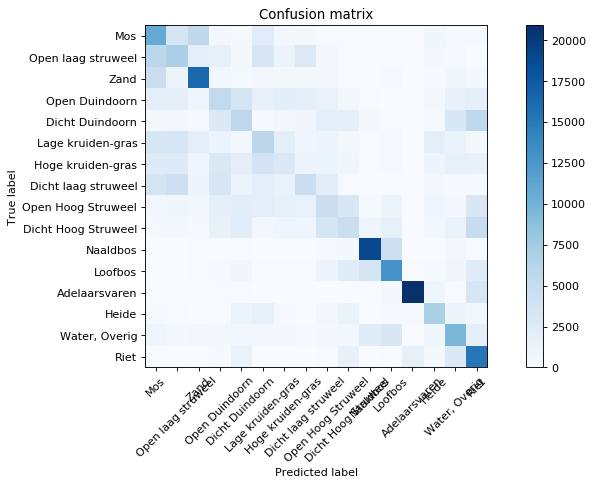

In [27]:
plot_confusion_matrix(confusion_matrix(annotations['label'],annotations['predict'], labels = annotations['label'].unique()))

In [ ]:
# check annotations if there are correct

In [186]:
def sum_sum_ndvi(x):
    try:
        sum(sum(x["kernel"]))
    except:
        return 0
    
annotations.apply(lambda x:sum_sum_ndvi(x['kernel'][0][0]), axis=1)

In [203]:
ndvi_array = []
for id,row in annotations.iterrows():
    try:
        ndvi_array.append(sum(sum(row['kernel'][0])))
    except:
        ndvi_array.append(0)

In [205]:
annotations['ndvi_sum'] = ndvi_array

In [206]:
ahn_array = []
for id,row in annotations.iterrows():
    try:
        ahn_array.append(sum(sum(row['kernel'][1])))
    except:
        ahn_array.append(0)

In [207]:
annotations['ahn_sum'] = ahn_array

In [213]:
annotations

,label,x,y,cor_x,cor_y,kernel,predict,ndvi_sum,ahn_sum
0,Mos,93927.25,479552.75,14979,2643,"[[[117, 118, 118, 118, 122, 129, 129, 129, 129...",Mos,93726,42608
1,Mos,93927.25,479551.75,14981,2643,"[[[118, 121, 123, 124, 128, 131, 130, 130, 133...",Mos,89697,35952
2,Mos,93928.25,479551.75,14981,2645,"[[[123, 124, 128, 131, 130, 130, 133, 135, 135...",Mos,87347,32960
3,Mos,93928.25,479552.75,14979,2645,"[[[118, 118, 122, 129, 129, 129, 129, 128, 128...",Mos,91264,39420
4,Mos,93927.25,479552.75,14979,2643,"[[[117, 118, 118, 118, 122, 129, 129, 129, 129...",Mos,93726,42608
...,...,...,...,...,...,...,...,...,...
392376,Riet,95940.25,482367.75,9349,6669,"[[[86, 112, 136, 143, 148, 155, 163, 168, 168,...",Heide,130482,77192
392377,Riet,95940.25,482366.75,9351,6669,"[[[75, 95, 119, 137, 145, 150, 156, 160, 163, ...",Heide,129831,74804
392378,Riet,95941.25,482366.75,9351,6671,"[[[119, 137, 145, 150, 156, 160, 163, 167, 167...",Heide,134741,84280
392379,Riet,95941.25,482367.75,9349,6671,"[[[136, 143, 148, 155, 163, 168, 168, 169, 168...",Heide,135069,86736


In [212]:
for label in annotations['label'].unique():
    print("--------")
    print(label)
    annotations_cur = annotations[annotations['label'] == str(label)]
    
    print(annotations_cur['ndvi_sum'].mean())
    print(annotations_cur['ndvi_sum'].median())
    
    print(annotations_cur['ahn_sum'].mean())
    print(annotations_cur['ahn_sum'].median())

--------
Mos
78382.7533104845
77112.0
19558.322752765227
16184.0
--------
Open laag struweel
86857.28493203883
87369.0
25973.28100970874
24610.0
--------
Zand
65303.36645471989
65280.0
37074.01346928026
20824.0
--------
Open Duindoorn
102338.7270870163
105694.0
39428.90567668434
37340.0
--------
Dicht Duindoorn
108595.89485943776
121372.0
55606.455341365465
56042.0
--------
Lage kruiden-gras
90983.93380958146
94085.0
36320.949832505954
26440.0
--------
Hoge kruiden-gras
99901.18291543373
100949.0
36881.6638374085
30898.0
--------
Dicht laag struweel
94851.17001380943
94850.0
34907.89536397711
32628.0
--------
Open Hoog Struweel
112164.11952630129
111090.0
64929.332612031314
61648.0
--------
Dicht Hoog Struweel
116038.69412002424
120396.0
72284.68332996564
71200.0
--------
Naaldbos
104549.8426280517
124770.0
168538.55864049785
176204.0
--------
Loofbos
128568.14206472725
137759.0
132762.4496188994
132880.0
--------
Adelaarsvaren
170199.3132331519
173697.0
29290.241470520585
20900.0
----

# Deep learning model.

In [82]:
def standard_convolutional_network(size_x_matrix =32 ,size_y_matrix = 32,bands = 6, no_classes =5):

     model = Sequential()
     model.add(Convolution2D(32, kernel_size=(3, 3), activation='relu', input_shape=(size_x_matrix,size_y_matrix,bands)))
     model.add(Convolution2D(64, kernel_size=(3, 3), activation='relu'))
     model.add(Convolution2D(128, kernel_size=(3, 3), activation='relu'))
     model.add(Flatten())
     model.add(Dense(128, activation='relu'))
     model.add(Dense(no_classes, activation='softmax'))
     return model

def VGG_16_inspired_model(size_x_matrix =32 ,size_y_matrix = 32,bands = 4, no_classes=5):
    model = Sequential()
    # model.add(ZeroPadding2D((1,1),input_shape=(31,31, 7)))
    model.add(Convolution2D(28, 2, 2, activation='relu',input_shape=((size_x_matrix, size_y_matrix, bands))))
    model.add(Convolution2D(56, 2, 2, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_classes, activation='softmax'))
    return model

In [86]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
 
# In the following lines, replace <username> with your username.
experiment_log_dir = "C:\\repos\\satellite-images-nso-datascience\\logs"
checkpoint_path = "C:\\repos\\satellite-images-nso-datascience\\model_check_points\\"+tif_file.split("/")[-1]+"keras_checkpoint_weights.ckpt"
 
tensorboard_callback = TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=3)

In [27]:
annotations_sample = annotations.sample(n=70000, random_state=1)

In [36]:
alabelencoder = LabelEncoder()
y = alabelencoder.fit_transform(annotations_sample['label'])

In [19]:
len_y = len(annotations_sample)

In [37]:
len_y 

70000

In [31]:
model = standard_convolutional_network(bands = 6, no_classes= len_y)

In [83]:
model = VGG_16_inspired_model(bands = 6, no_classes= len_y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(28, (2, 2), activation="relu", input_shape=(32, 32, 6...)`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(56, (2, 2), activation="relu")`
  app.launch_new_instance()


In [87]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= 'rmsprop',
              metrics=['accuracy'])

In [29]:
reshape_file = np.concatenate(annotations_sample["kernel"].values).reshape(len_y,32,32,6).astype(int)

In [ ]:
model.fit(reshape_file,y.reshape(len_y,1), epochs=30, callbacks=[ model_checkpoint, early_stopping])

Epoch 1/30
70000/70000 [==============================] - 1113s 16ms/step - loss: 2.3940 - accuracy: 0.2607
Epoch 2/30


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


39552/70000 [===============>..............] - ETA: 15:40 - loss: 2.1700 - accuracy: 0.3058

In [66]:
model.save('standard_convolutional_network_2019_AWD_RGBI_NDVI_H')

In [19]:
model = keras.models.load_model('standard_convolutional_network_2019_AWD_RGBI_NDVI_H')

In [22]:
def dl_predict(model, akernel):
        return model.predict(np.concatenate(akernel).reshape(len(akernel),32,32,6))

In [88]:
len(annotations)

391998

In [94]:
del annotations_sample

In [39]:
sample_test_annotations = annotations.sample(n=50000, random_state=1)

In [44]:
del sample_test_annotations

In [40]:
labels_othot = dl_predict(model,sample_test_annotations['kernel'].values)

In [41]:
sample_test_annotations['predict'] = [alabelencoder.inverse_transform([np.argmax(alabelothot)])[0] for alabelothot in labels_othot]

In [42]:
len(sample_test_annotations[sample_test_annotations['label'] == sample_test_annotations['predict']])/len(sample_test_annotations)

0.43196

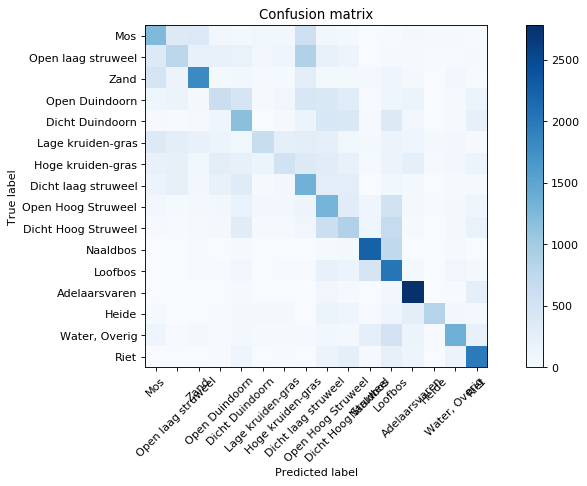

In [43]:
plot_confusion_matrix(confusion_matrix(sample_test_annotations['label'],sample_test_annotations['predict'], labels = annotations['label'].unique()))